In [2]:
!ls
!pip install imutils

CCPD		data.csv	models			    word_to_idx.csv
MNIST		fixed_danish	quick_start_pytorch.ipynb
README.md	history		quick_start_pytorch_images
danish_license	lightning_logs	skipgram.ipynb


### Setup

In [3]:
# External libraries used for various tasks in later parts of the code
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import time
import numpy as np
import torch.optim as optim
from tqdm.notebook import tqdm
import os

# Check if running on Google Colab and set the data paths accordingly
is_running_on_colab = 'COLAB_GPU' in os.environ
if is_running_on_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    train_path = '/content/gdrive/MyDrive/license_plate/CCPD/train/'
    val_path = '/content/gdrive/MyDrive/license_plate/CCPD/val/'
    test_path = '/content/gdrive/MyDrive/license_plate/CCPD/test/'

    train_danish_path = '/content/gdrive/MyDrive/license_plate/danish_license/train'
    val_danish_path = '/content/gdrive/MyDrive/license_plate/danish_license/val'
    test_danish_path = '/content/gdrive/MyDrive/license_plate/danish_license/test'
else:
    current_dir = os.getcwd()
    train_path = os.path.join(current_dir, 'CCPD', 'train')
    val_path = os.path.join(current_dir, 'CCPD', 'val')
    test_path = os.path.join(current_dir, 'CCPD', 'test')
    train_danish_path = os.path.join(current_dir, 'fixed_danish', 'train')
    val_danish_path = os.path.join(current_dir, 'fixed_danish', 'val')
    test_danish_path = os.path.join(current_dir, 'fixed_danish','test')
# Function to check if directories exist
def check_directories_exist(*paths):
    for path in paths:
        assert os.path.isdir(path), f"The directory {path} does not exist."

# Check the directories
check_directories_exist(train_path, val_path, test_path, train_danish_path, val_danish_path, test_danish_path)

# Sets device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_PATH = [train_path]
VAL_PATH = [val_path]
TEST_PATH = [test_path]
TRAIN_DANISH_PATH = [train_danish_path]
VAL_DANISH_PATH = [val_danish_path]
TEST_DANISH_PATH = [test_danish_path]

**Check how many images in data-split**

In [4]:
# Function to count files in a directory
def count_files_in_directory(directory):
    return len(os.listdir(directory))

# Check the number of files in each path
train_files = count_files_in_directory(train_path)
val_files = count_files_in_directory(val_path)
test_files = count_files_in_directory(test_path)
train_danish_files = count_files_in_directory(train_danish_path)

# Print the results
print(f"Number of files in train path: {train_files}")
print(f"Number of files in val path: {val_files}")
print(f"Number of files in test path: {test_files}")
print(f"Number of files in danish train path: {train_danish_files}")
print(f"Number of files in danish val path: {count_files_in_directory(val_danish_path)}")
print(f"Number of files in danish test path: {count_files_in_directory(test_danish_path)}")



Number of files in train path: 5769
Number of files in val path: 1001
Number of files in test path: 5006
Number of files in danish train path: 77
Number of files in danish val path: 22
Number of files in danish test path: 53


### DataLoader


In [5]:

from torch.utils.data import Dataset
import cv2
from imutils import paths
import os
import torch

class LabelFpsDataLoader(Dataset):
    def __init__(self, img_dirs, img_size, is_transform=None, normalize_labels=False, augmentation_function=None):
        self.img_paths = [p for img_dir in img_dirs for p in paths.list_images(img_dir)]
        self.img_size = img_size
        self.is_transform = is_transform
        self.normalize_labels = normalize_labels
        if augmentation_function is None:
            augmentation_function = lambda x: x
        self.augmentation_function = augmentation_function

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_name = self.img_paths[index]
        img = cv2.imread(img_name)
        img = self.augmentation_function(img)
        resized_image = self.transform_image(img)

        file_name = os.path.splitext(os.path.basename(img_name))[0]
        labels = self.extract_labels(file_name, img.shape)
        resized_image = resized_image.transpose(2, 0, 1)
        return resized_image, labels, img_name

    def transform_image(self, img):
        resized_image = cv2.resize(img, self.img_size).astype('float32') / 255.0
        # Normalization - Adjust mean and std if necessary
        mean = np.array([0.485, 0.456, 0.406], dtype=resized_image.dtype)
        std = np.array([0.229, 0.224, 0.225],dtype=resized_image.dtype)

        resized_image = (resized_image - mean) / std  # Normalize
        return resized_image

    def extract_labels(self, file_name, img_shape):
        parts = file_name.split('-')
        points = [self.parse_point(part) for part in parts[2].split('_')]
        ori_w, ori_h = img_shape[1], img_shape[0]
        scale_w, scale_h = self.img_size[0] / ori_w, self.img_size[1] / ori_h
        scaled_points = [(int(x * scale_w), int(y * scale_h)) for x, y in points]
        if self.normalize_labels:
          scaled_points = [(x / self.img_size[0], y / self.img_size[1]) for x, y in scaled_points]
        flattened_labels = [coord for point in scaled_points for coord in point]
        return torch.tensor(flattened_labels, dtype=torch.float32)

    @staticmethod
    def parse_point(point_str):
        return tuple(int(coord) for coord in point_str.split('&'))


### Helper methods

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_img_and_boundingbox(image, labels, img_size):
    # Assuming image is a PyTorch tensor, we need to first move it to CPU if it's on GPU,
    # then detach it from the current graph, convert to numpy, and finally transpose it
    # from (channels, height, width) to (height, width, channels)
    numpy_array = image.cpu().detach().numpy()
    print(numpy_array.shape)
    numpy_array = numpy_array.transpose(1,2,0)
    # Convert from BGR to RGB format if the image was read by OpenCV
    rgb_image = cv2.cvtColor(numpy_array, cv2.COLOR_BGR2RGB)
    # rgb_image = numpy_array.transpose(1,2,0)
    # Extract numerical values from tensors and convert to integers
    left_up = (int(labels[0]*img_size), int(labels[1]*img_size))
    right_down = (int(labels[2]*img_size), int(labels[3]*img_size))

    # Draw rectangle on the image
    new_image = cv2.rectangle(rgb_image, left_up, right_down, (255, 0, 0), 2)

    # Display the image
    plt.imshow(new_image)
    plt.axis('off')  # Hide the axis
    plt.show()

# Example usage:
# img, labels, _ = dataset[0]  # Assuming this is how you get an image and labels from your dataset
# plot_img_and_boundingbox(img, labels)


In [7]:
def save_model(model, filename = None):
    # Get the current time
    current_time = datetime.now()

    # Format the time in a 'YearMonthDay_HourMinuteSecond' format for the filename
    timestamp = current_time.strftime('%Y%m%d_%H%M')
    if is_running_on_colab:
        if filename is not None:
            model_path = f'/content/gdrive/MyDrive/license_plate/models/{filename}.pth'
        else:
            model_path = f'/content/gdrive/MyDrive/license_plate/models/model_weights_{timestamp}.pth'
    else:
        if filename is not None:
            model_path = os.path.join(current_dir, 'models', f'{filename}.pth')
        else:
            model_path = os.path.join(current_dir, 'models', f'model_weights_{timestamp}.pth')
    torch.save(model.state_dict(), model_path)

def load_model(path):
    model = get_new_model()
    model.load_state_dict(torch.load(path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    return model

import json

def save_history_to_file(history, filename=None):
    current_time = datetime.now()
    timestamp = current_time.strftime('%Y%m%d_%H%M')
    current_dir = os.getcwd()
    
    if is_running_on_colab:
        if filename is not None:
            history_path = f'/content/gdrive/MyDrive/license_plate/history/{filename}.json'
        else:
            history_path = f'/content/gdrive/MyDrive/license_plate/history/history_{timestamp}.json'
    else:
        if filename is not None:
            history_path = os.path.join(current_dir, 'history', f'{filename}.json')
        else:
            history_path = os.path.join(current_dir, 'history', f'history_{timestamp}.json')

    with open(history_path, 'w') as file:
        json.dump(history, file)

def load_history_from_file(file_path):
    with open(file_path, 'r') as file:
        history = json.load(file)
    return history

In [8]:
def bb_intersection_over_union(boxA, boxB):
    # Compute the intersection over union on GPU
    # Assumes boxA and boxB are tensors
    xA = torch.max(boxA[..., 0], boxB[..., 0])
    yA = torch.max(boxA[..., 1], boxB[..., 1])
    xB = torch.min(boxA[..., 2], boxB[..., 2])
    yB = torch.min(boxA[..., 3], boxB[..., 3])

    interArea = torch.clamp(xB - xA, min=0) * torch.clamp(yB - yA, min=0)

    boxAArea = (boxA[..., 2] - boxA[..., 0]) * (boxA[..., 3] - boxA[..., 1])
    boxBArea = (boxB[..., 2] - boxB[..., 0]) * (boxB[..., 3] - boxB[..., 1])

    iou = interArea / (boxAArea + boxBArea - interArea)
    return iou

def calculate_true_positives_in_batch(y_pred, y_batch, threshold=0.7):
    # Calculate IoU for the batch
    iou = bb_intersection_over_union(y_pred, y_batch)

    # Count true positives in the batch
    true_positives = torch.sum(iou > threshold).item()
    return true_positives

def calculate_loss_and_accuracy(loader, model, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_true_positives = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for X_batch, y_batch, _ in loader:
            # X_batch = X_batch.permute(0,3,1,2).to(device)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)

            total_true_positives += calculate_true_positives_in_batch(y_pred, y_batch)

            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item() * X_batch.size(0)  # Accumulate scaled loss
            total_samples += X_batch.size(0)  # Accumulate number of samples

    sample_loss = total_loss / total_samples  # Calculate average loss
    accuracy = total_true_positives / total_samples  # Calculate accuracy
    return sample_loss, accuracy

In [9]:
def check_requires_grad(model):
  for name, param in model.named_parameters():
    if name.startswith('classifier'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')
    if name.startswith('features'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')


In [10]:
import matplotlib.pylab as plt

def plot_history(history, baseline_loss=None, baseline_acc=None):
    eval_epochs = range(1, len(history['in_loss']) + 1)

    # Plot for loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(eval_epochs, history['in_loss'], 'b', label='Train Loss')
    plt.plot(eval_epochs, history['out_loss'], 'r', label='Val Loss')
    if baseline_loss is not None:
        plt.axhline(y=baseline_loss, color='g', linestyle='--', label=f'Baseline Loss')
    # plt.title('Loss')
    plt.xlabel('Epochs with evaluation')
    plt.ylabel('Loss (SmoothL1)')
    plt.legend()

    # Plot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(eval_epochs, history['in_acc'], 'b', label='Train Acc')
    plt.plot(eval_epochs, history['out_acc'], 'r', label='Val Acc')
    if baseline_acc is not None:
        plt.axhline(y=baseline_acc, color='g', linestyle='--', label=f'Baseline Acc')
    # plt.title('Accuracy')
    plt.xlabel('Epochs with evaluation')
    plt.ylabel('Accuracy (IoU>0.7)')
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlapping

    plt.show()

### Model


In [11]:
import torch
import torch.nn as nn

# Function to create the modified classifier
def create_custom_classifier(input_features, hidden_units, output_features):
    classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        # nn.Dropout(0.0),
        #nn.BatchNorm1d(hidden_units),
        nn.Linear(hidden_units, output_features),
    )
    return classifier

# Load a pre-trained MobileNetV3 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)

def get_new_model():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)
    model.classifier = create_custom_classifier(input_features=960, hidden_units=100, output_features=4)

    # Set the model to evaluation mode if not training
    model.eval()

    # Number of layers you want to fine-tune
    layers_of_classifier = len(model.classifier)

    # Get all the parameters from the model as a list
    parameters = list(model.parameters())

    # The total number of layers is the length of the parameters list
    number_of_layers = len(parameters)

    # Calculate the number of pretrained layers (all except the last 'layers_of_classifier')
    pretrained_layers = number_of_layers - layers_of_classifier

    # Freeze the parameters of the pretrained base layers
    for param in parameters[:-layers_of_classifier]:
        param.requires_grad = False

    # Unfreeze the parameters of the last 'layers_of_classifier' layers
    for param in parameters[-layers_of_classifier:]:
        param.requires_grad = True
    model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    return model
# model = get_new_model()
# check_requires_grad(model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


### Constants & dataset initialization

In [12]:
import torch
from torch.utils.data import DataLoader, Subset
from datetime import datetime
from tqdm import tqdm

# Constants
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

SUBSET_INDICES = 100
SUBSET_VAL_INDICES = 200
SUBSET_TEST_INDICES = 50

DECODER_EPOCHS = 10
#N_EPOCHS_CYCLIC = 10
N_EPOCHS_LINEAR = 20

USE_TQDM = True
USE_SUBSET = False
NORMALIZED_LABELS = False
EVAL_EVERY = 1

loss_fn = nn.MSELoss()

# Define dataloaders

# Training
train_dataset = LabelFpsDataLoader(TRAIN_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True)

# Validation
val_dataset = LabelFpsDataLoader(VAL_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Test
test_dataset = LabelFpsDataLoader(TEST_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Danish
train_danish_dataset = LabelFpsDataLoader(TRAIN_DANISH_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
train_danish_loader = DataLoader(train_danish_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle = True, num_workers=2, pin_memory=True)

val_danish_dataset = LabelFpsDataLoader(VAL_DANISH_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
val_danish_loader = DataLoader(train_danish_dataset, batch_size=VAL_BATCH_SIZE, shuffle = True, num_workers=2, pin_memory=True)

test_danish_dataset = LabelFpsDataLoader(TEST_DANISH_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
test_danish_loader = DataLoader(train_danish_dataset, batch_size=TEST_BATCH_SIZE, shuffle = True, num_workers=2, pin_memory=True)


# Use subsets for faster iterations during development
if USE_SUBSET:
    # Training
    train_dataset = Subset(train_dataset, indices=range(SUBSET_INDICES))
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    # Validation
    val_dataset = Subset(val_dataset, indices=range(SUBSET_VAL_INDICES))
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)
    # Test
    test_dataset = Subset(test_dataset, indices=range(SUBSET_TEST_INDICES))
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=2)

### Training & test methods

In [13]:
# Define model, loss function, optimizers, and schedulers
def train_full_model(model, train_loader, val_loader):
  model.to(device)
  loss_fn = nn.SmoothL1Loss()

  optimizer_decoder = optim.AdamW(model.parameters(), lr=1e-3)
  scheduler_decoder = optim.lr_scheduler.StepLR(optimizer_decoder, step_size=int(DECODER_EPOCHS/3), gamma=0.5, verbose = False)
  # scheduler_decoder = optim.lr_scheduler.ReduceLROnPlateau(optimizer_decoder, mode='min', factor=0.1, patience=2, verbose=True)


  # Train the model with the decoder first
  print("Starting training with decoder...")
  decoder_in_loss, decoder_out_loss, decoder_in_acc, decoder_out_acc = train_model(
      n_epochs=DECODER_EPOCHS,
      optimizer=optimizer_decoder,
      scheduler=scheduler_decoder,
      dataloader=train_loader,
      val_loader=val_loader,
      model=model,
      loss_fn=loss_fn
  )

  # Unfreeze model layers for full model training
  for param in model.parameters():
      param.requires_grad = True


  print("Starting full model training...")
  optimizer_full_linear = optim.AdamW(model.parameters(), lr=1e-3)
  scheduler_full_linear = optim.lr_scheduler.StepLR(optimizer_full_linear, step_size=int(N_EPOCHS_LINEAR/3), gamma=0.1, verbose = False)
  # scheduler_full_linear = optim.lr_scheduler.ReduceLROnPlateau(optimizer_full_linear, mode='min', factor=0.1, patience=2, verbose=True)
  linear_in_loss, linear_out_loss, linear_in_acc, linear_out_acc = train_model(
      n_epochs=N_EPOCHS_LINEAR,
      optimizer=optimizer_full_linear,
      scheduler=scheduler_full_linear,
      dataloader=train_loader,  # Assuming train_loader_finetuning is the same as train_loader
      val_loader=val_loader,
      model=model,
      loss_fn=loss_fn
  )
  total_in_loss = decoder_in_loss + linear_in_loss
  total_out_loss = decoder_out_loss + linear_out_loss
  total_in_acc = decoder_in_acc + linear_in_acc
  total_out_acc = decoder_out_acc + linear_out_acc
  history = {'in_loss': total_in_loss, 'out_loss': total_out_loss, 'in_acc': total_in_acc, 'out_acc': total_out_acc}
  return model, history


In [14]:
import torch
from torch.utils.data import DataLoader, Subset
from datetime import datetime
from tqdm import tqdm

# Training functions
def train_epoch(dataloader, optimizer, model, loss_fn, scaler):
    # with torch.autograd.profiler.profile(use_cuda=True, profile_memory=True) as prof:
    for X_batch, y_batch, _ in dataloader:
        optimizer.zero_grad()
        X_batch = X_batch.to(device)
        # X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        with torch.cuda.amp.autocast():
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    # print(prof.key_averages().table(sort_by="cuda_time_total"))

def train_model(n_epochs, optimizer, scheduler, dataloader, val_loader, model, loss_fn):
    in_loss_history = []
    out_loss_history = []
    in_acc_history = []
    out_acc_history = []
    scaler = torch.cuda.amp.GradScaler()
    best_out_acc = 0
    best_model_dict = model.state_dict()

    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_loss = train_epoch(dataloader, optimizer, model, loss_fn, scaler)
        scheduler.step()

        if epoch % EVAL_EVERY == 0:
            model.eval()
            with torch.no_grad():
                # In-sample
                in_sample_loss, in_sample_accuracy = calculate_loss_and_accuracy(dataloader, model, loss_fn, device)
                in_loss_history.append(in_sample_loss)
                in_acc_history.append(in_sample_accuracy)

                # Out-sample
                out_sample_loss, out_sample_accuracy = calculate_loss_and_accuracy(val_loader, model, loss_fn, device)
                out_loss_history.append(out_sample_loss)
                out_acc_history.append(out_sample_accuracy)
                if out_sample_accuracy > best_out_acc:
                    tqdm.write(f'New best model found with out-sample accuracy: {out_sample_accuracy:.4f}')
                    best_out_acc = out_sample_accuracy
                    best_model_dict = model.state_dict()

                if USE_TQDM:
                    tqdm.write(f'Epoch {epoch + 1}, In-sample Loss: {in_sample_loss:.4f}, In-sample Accuracy: {in_sample_accuracy:.4f}')
                    tqdm.write(f'Epoch {epoch + 1}, Out-sample Loss: {out_sample_loss:.4f}, Out-sample Accuracy: {out_sample_accuracy:.4f}')
    #Føj Niklas
    model = model.load_state_dict(best_model_dict)
    return in_loss_history, out_loss_history, in_acc_history, out_acc_history

In [15]:
import torch
import torch.nn.functional as F

def test_model(model, test_loader, threshold=0.7):
    model.eval()  # Set the model to evaluation mode
    total_true_positives = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets, _ in tqdm(test_loader):
            inputs = inputs.to(device)#permute(0, 3, 1, 2).to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate true positives for the batch
            true_positives = calculate_true_positives_in_batch(outputs, targets, threshold)

            total_true_positives += true_positives
            total_samples += targets.size(0)

            # Calculate loss for the batch
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

    # Calculate accuracy and average loss
    accuracy = total_true_positives / total_samples
    average_loss = total_loss / len(test_loader)

    return accuracy, average_loss

### Experiment: Standard acc and loss

In [16]:
model = get_new_model()
trained_model, history = train_full_model(model,train_loader, val_loader)
# save_model(trained_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Starting training with decoder...


  0%|          | 0/10 [00:17<?, ?it/s]


KeyboardInterrupt: 

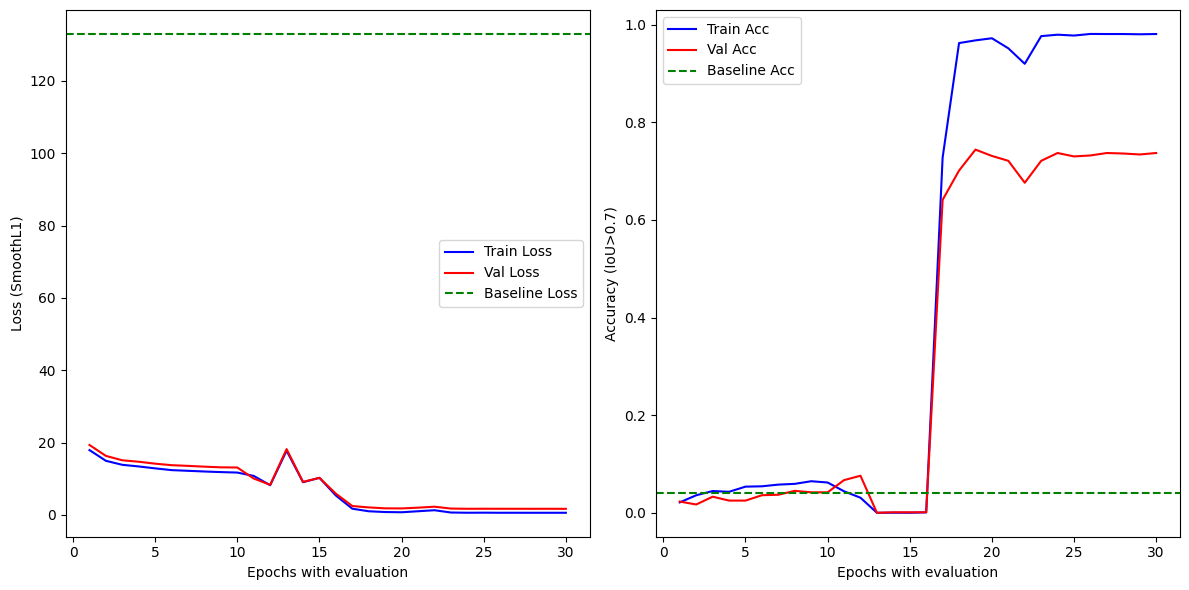

100%|██████████| 79/79 [00:45<00:00,  1.74it/s]


(0.7339192968437874, 20.87101242813883)

In [ ]:
plot_history(history, 133, 0.04)
filename = "drop_50_epoch_10_20_earlystop_green_original_L1_non_normalized_scratch"
save_history_to_file(history, filename)
save_model(trained_model, filename)
test_model(trained_model, test_loader)

In [ ]:
model = get_new_model()
trained_model, history = train_full_model(model,train_loader, val_loader)
save_model(trained_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Adjusting learning rate of group 0 to 1.0000e-03.
Starting training with decoder...


  0%|          | 0/10 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


 10%|█         | 1/10 [00:23<03:35, 23.95s/it]

Epoch 1, In-sample Loss: 0.0055, In-sample Accuracy: 0.0213
Epoch 1, Out-sample Loss: 0.0066, Out-sample Accuracy: 0.0100
Adjusting learning rate of group 0 to 1.0000e-03.


 20%|██        | 2/10 [00:47<03:10, 23.80s/it]

Epoch 2, In-sample Loss: 0.0042, In-sample Accuracy: 0.0376
Epoch 2, Out-sample Loss: 0.0055, Out-sample Accuracy: 0.0280
Adjusting learning rate of group 0 to 5.0000e-04.


 30%|███       | 3/10 [01:10<02:43, 23.43s/it]

Epoch 3, In-sample Loss: 0.0032, In-sample Accuracy: 0.0633
Epoch 3, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0380
Adjusting learning rate of group 0 to 5.0000e-04.


 40%|████      | 4/10 [01:35<02:23, 23.85s/it]

Epoch 4, In-sample Loss: 0.0032, In-sample Accuracy: 0.0783
Epoch 4, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0579
Adjusting learning rate of group 0 to 5.0000e-04.


 50%|█████     | 5/10 [01:59<01:59, 23.89s/it]

Epoch 5, In-sample Loss: 0.0028, In-sample Accuracy: 0.0811
Epoch 5, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0609
Adjusting learning rate of group 0 to 2.5000e-04.


 60%|██████    | 6/10 [02:23<01:35, 23.97s/it]

Epoch 6, In-sample Loss: 0.0027, In-sample Accuracy: 0.0903
Epoch 6, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0519
Adjusting learning rate of group 0 to 2.5000e-04.


 70%|███████   | 7/10 [02:46<01:11, 23.82s/it]

Epoch 7, In-sample Loss: 0.0026, In-sample Accuracy: 0.0990
Epoch 7, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0749
Adjusting learning rate of group 0 to 2.5000e-04.


 80%|████████  | 8/10 [03:09<00:47, 23.58s/it]

Epoch 8, In-sample Loss: 0.0026, In-sample Accuracy: 0.1042
Epoch 8, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0739
Adjusting learning rate of group 0 to 1.2500e-04.


 90%|█████████ | 9/10 [03:34<00:23, 23.88s/it]

Epoch 9, In-sample Loss: 0.0024, In-sample Accuracy: 0.1156
Epoch 9, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0819
Adjusting learning rate of group 0 to 1.2500e-04.


100%|██████████| 10/10 [03:59<00:00, 23.94s/it]


Epoch 10, In-sample Loss: 0.0024, In-sample Accuracy: 0.1116
Epoch 10, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0719
Starting full model training...
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▌         | 1/20 [00:24<07:47, 24.62s/it]

Epoch 1, In-sample Loss: 0.0034, In-sample Accuracy: 0.0888
Epoch 1, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.1309
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|█         | 2/20 [00:49<07:26, 24.82s/it]

Epoch 2, In-sample Loss: 0.0029, In-sample Accuracy: 0.0761
Epoch 2, Out-sample Loss: 0.0031, Out-sample Accuracy: 0.1728
Adjusting learning rate of group 0 to 1.0000e-03.


 15%|█▌        | 3/20 [01:15<07:09, 25.26s/it]

Epoch 3, In-sample Loss: 0.0018, In-sample Accuracy: 0.0738
Epoch 3, Out-sample Loss: 0.0018, Out-sample Accuracy: 0.1429
Adjusting learning rate of group 0 to 1.0000e-03.


 20%|██        | 4/20 [01:39<06:37, 24.82s/it]

Epoch 4, In-sample Loss: 0.0008, In-sample Accuracy: 0.5098
Epoch 4, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.6154
Adjusting learning rate of group 0 to 1.0000e-03.


 25%|██▌       | 5/20 [02:04<06:12, 24.85s/it]

Epoch 5, In-sample Loss: 0.0006, In-sample Accuracy: 0.0068
Epoch 5, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0270
Adjusting learning rate of group 0 to 1.0000e-04.


 30%|███       | 6/20 [02:29<05:49, 24.99s/it]

Epoch 6, In-sample Loss: 0.0008, In-sample Accuracy: 0.0033
Epoch 6, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0300
Adjusting learning rate of group 0 to 1.0000e-04.


 35%|███▌      | 7/20 [02:55<05:27, 25.16s/it]

Epoch 7, In-sample Loss: 0.0002, In-sample Accuracy: 0.8927
Epoch 7, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.6783
Adjusting learning rate of group 0 to 1.0000e-04.


 40%|████      | 8/20 [03:19<04:59, 24.93s/it]

Epoch 8, In-sample Loss: 0.0000, In-sample Accuracy: 0.9794
Epoch 8, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.7303
Adjusting learning rate of group 0 to 1.0000e-04.


 45%|████▌     | 9/20 [03:45<04:35, 25.07s/it]

Epoch 9, In-sample Loss: 0.0001, In-sample Accuracy: 0.9581
Epoch 9, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.7323
Adjusting learning rate of group 0 to 1.0000e-04.


 50%|█████     | 10/20 [04:10<04:10, 25.06s/it]

Epoch 10, In-sample Loss: 0.0001, In-sample Accuracy: 0.9724
Epoch 10, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.7712
Adjusting learning rate of group 0 to 1.0000e-04.


 55%|█████▌    | 11/20 [04:35<03:46, 25.16s/it]

Epoch 11, In-sample Loss: 0.0000, In-sample Accuracy: 0.9821
Epoch 11, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.7453
Adjusting learning rate of group 0 to 1.0000e-05.


 60%|██████    | 12/20 [05:00<03:21, 25.23s/it]

Epoch 12, In-sample Loss: 0.0001, In-sample Accuracy: 0.9711
Epoch 12, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.7403
Adjusting learning rate of group 0 to 1.0000e-05.


 65%|██████▌   | 13/20 [05:26<02:56, 25.24s/it]

Epoch 13, In-sample Loss: 0.0000, In-sample Accuracy: 0.9841
Epoch 13, Out-sample Loss: 0.0002, Out-sample Accuracy: 0.7443
Adjusting learning rate of group 0 to 1.0000e-05.


 70%|███████   | 14/20 [05:51<02:31, 25.31s/it]

Epoch 14, In-sample Loss: 0.0000, In-sample Accuracy: 0.9842
Epoch 14, Out-sample Loss: 0.0002, Out-sample Accuracy: 0.7483
Adjusting learning rate of group 0 to 1.0000e-05.


 75%|███████▌  | 15/20 [06:16<02:05, 25.16s/it]

Epoch 15, In-sample Loss: 0.0000, In-sample Accuracy: 0.9842
Epoch 15, Out-sample Loss: 0.0002, Out-sample Accuracy: 0.7423
Adjusting learning rate of group 0 to 1.0000e-05.


 80%|████████  | 16/20 [06:41<01:40, 25.18s/it]

Epoch 16, In-sample Loss: 0.0000, In-sample Accuracy: 0.9847
Epoch 16, Out-sample Loss: 0.0002, Out-sample Accuracy: 0.7453
Adjusting learning rate of group 0 to 1.0000e-05.


 85%|████████▌ | 17/20 [07:06<01:15, 25.07s/it]

Epoch 17, In-sample Loss: 0.0000, In-sample Accuracy: 0.9837
Epoch 17, Out-sample Loss: 0.0002, Out-sample Accuracy: 0.7393
Adjusting learning rate of group 0 to 1.0000e-06.


 90%|█████████ | 18/20 [07:31<00:49, 24.96s/it]

Epoch 18, In-sample Loss: 0.0000, In-sample Accuracy: 0.9815
Epoch 18, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.7303
Adjusting learning rate of group 0 to 1.0000e-06.


 95%|█████████▌| 19/20 [07:56<00:25, 25.11s/it]

Epoch 19, In-sample Loss: 0.0000, In-sample Accuracy: 0.9849
Epoch 19, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.7383
Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 20/20 [08:21<00:00, 25.06s/it]

Epoch 20, In-sample Loss: 0.0000, In-sample Accuracy: 0.9856
Epoch 20, Out-sample Loss: 0.0002, Out-sample Accuracy: 0.7423


In [ ]:
save_model(trained_model)

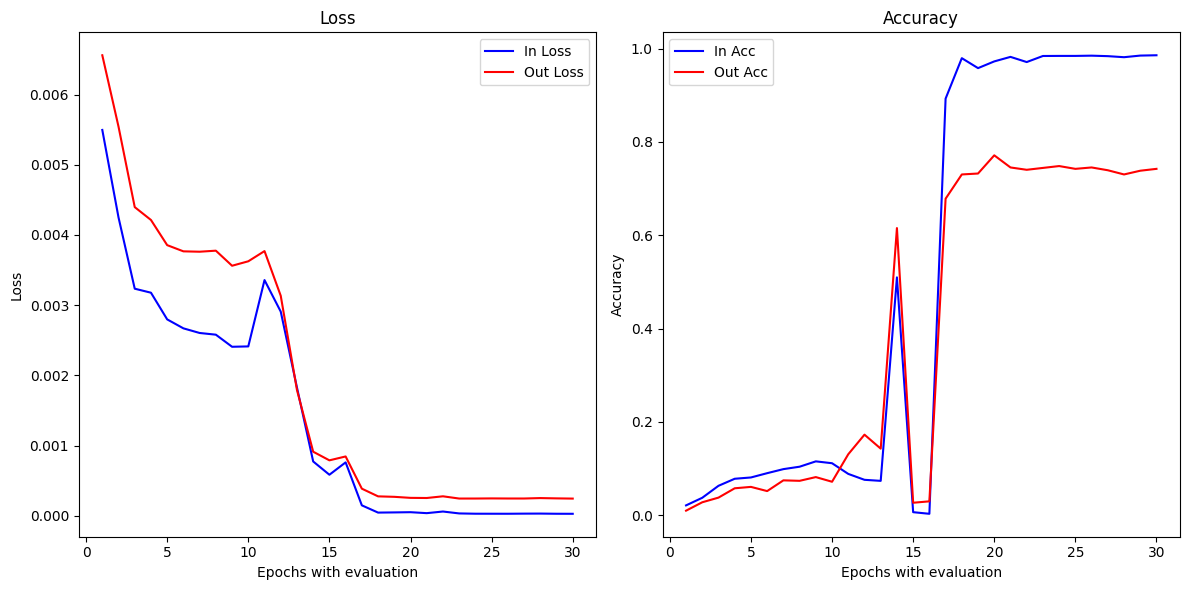

In [ ]:
plot_history(history)
save_history_to_file(history)

In [ ]:
# accuracy, average_loss = test_model(model, test_loader)

# print(f'\nTest Accuracy: {accuracy * 100:.2f}%')
# print(f'Average Test Loss: {average_loss:.4f}')

In [ ]:
# model = load_model('/content/gdrive/MyDrive/license_plate/models/best_model_1130.pth')
# model1, history = train_full_model(model, train_danish_loader, val_danish_loader)
# accuracyTrain, averageTrain_loss = test_model(model1, train_danish_loader)
# accuracy, average_loss = test_model(model1, val_danish_loader)

# print(f'\nTrain Accuracy: {accuracyTrain * 100:.2f}%')
# print(f'Average train Loss: {averageTrain_loss:.4f}')

# print(f'\nTest Accuracy: {accuracy * 100:.2f}%')
# print(f'Average Test Loss: {average_loss:.4f}')

### Experiment: Tranfer learning to danish licence plates

In [ ]:
# model = load_model('/content/gdrive/MyDrive/license_plate/models/best_model_1130.pth')
# model1, history = train_full_model(model, train_danish_loader, val_danish_loader)
# accuracyTrain, averageTrain_loss = test_model(model1, train_danish_loader)
# accuracy, average_loss = test_model(model1, val_danish_loader)

# print(f'\nTrain Accuracy: {accuracyTrain * 100:.2f}%')
# print(f'Average train Loss: {averageTrain_loss:.4f}')

# print(f'\nTest Accuracy: {accuracy * 100:.2f}%')
# print(f'Average Test Loss: {average_loss:.4f}')

In [ ]:
# model = get_new_model()
# trained_model, history = train_full_model(model, train_danish_loader, val_danish_loader)
# plot_history(history)

### Experiment: Normalized labels & learning rate

In [ ]:

lr_to_test = [(1e-4, 1e-2),(1e-4, 1e-1),(1e-3, 1e-2)]

in_loss_standard_hist = []
out_loss_standard_hist = []

in_acc_standard_hist = []
out_acc_standard_hist = []


for index, (lr_base, lr_max) in enumerate(lr_to_test):
  model = get_new_model()
  cyclic_lr = {'base_lr': lr_base, 'max_lr': lr_max}
  _, history = train_full_model(model, cyclic_lr)
  in_loss_standard_hist.append(history['in_loss'])
  out_loss_standard_hist.append(history['out_loss'])
  in_acc_standard_hist.append(history['in_acc'])
  out_acc_standard_hist.append(history['out_acc'])



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


TypeError: train_full_model() missing 1 required positional argument: 'val_loader'

In [ ]:
# Now with normalized labels

# Define new dataloaders:

# Training
train_dataset = LabelFpsDataLoader(TRAIN_PATH, (224, 224), normalize_labels=True)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)

# Validation
val_dataset = LabelFpsDataLoader(VAL_PATH, (224, 224), normalize_labels=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)

# Test
test_dataset = LabelFpsDataLoader(TEST_PATH, (224, 224), normalize_labels=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=2)



# Use subsets for faster iterations during development
if USE_SUBSET:
    # Training
    train_dataset = Subset(train_dataset, indices=range(SUBSET_INDICES))
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    # Validation
    val_dataset = Subset(val_dataset, indices=range(SUBSET_VAL_INDICES))
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)
    # Test
    test_dataset = Subset(test_dataset, indices=range(SUBSET_TEST_INDICES))
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=2)

in_loss_normalized_hist = []
out_loss_normalized_hist = []

in_acc_normalized_hist = []
out_acc_normalized_hist = []


for index, (lr_base, lr_max) in enumerate(lr_to_test):
  model = get_new_model()
  cyclic_lr = {'base_lr': lr_base, 'max_lr': lr_max}
  _, history = train_full_model(model, cyclic_lr)
  in_loss_normalized_hist.append(history['in_loss'])
  out_loss_normalized_hist.append(history['out_loss'])
  in_acc_normalized_hist.append(history['in_acc'])
  out_acc_normalized_hist.append(history['out_acc'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

eval_epochs = range(1, len(in_loss_standard_hist[0]) + 1)

plt.figure(figsize=(12, 6))
for i, (lr_base, lr_max) in enumerate(lr_to_test):
    # Plot for standard
    plt.subplot(2, len(lr_to_test), i + 1)
    plt.plot(eval_epochs, in_loss_standard_hist[i], 'b', label='In Loss')
    plt.plot(eval_epochs, out_loss_standard_hist[i], 'r', label='Out Loss')
    plt.title(f'Loss with lr {lr_base} to {lr_max} (standard)')
    plt.xlabel('Epochs with evaluations')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for normalized
    plt.subplot(2, len(lr_to_test), len(lr_to_test) + i + 1)
    plt.plot(eval_epochs, in_loss_normalized_hist[i], 'b', label='In Loss')
    plt.plot(eval_epochs, out_loss_normalized_hist[i], 'r', label='Out Loss')
    plt.title(f'Loss with lr {lr_base} to {lr_max} (normalized)')
    plt.xlabel('Epochs with evaluations')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

eval_epochs = range(1, len(in_acc_standard_hist[0]) + 1)

plt.figure(figsize=(12, 6))
for i, (lr_base, lr_max) in enumerate(lr_to_test):
    # Plot for standard
    plt.subplot(2, len(lr_to_test), i + 1)
    plt.plot(eval_epochs, in_acc_standard_hist[i], 'b', label='In Acc')
    plt.plot(eval_epochs, out_loss_standard_hist[i], 'r', label='Out Acc')
    plt.title(f'Acc with lr {lr_base} to {lr_max} (standard)')
    plt.xlabel('Epochs with evaluations')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot for normalized
    plt.subplot(2, len(lr_to_test), len(lr_to_test) + i + 1)
    plt.plot(eval_epochs, in_acc_normalized_hist[i], 'b', label='In Acc')
    plt.plot(eval_epochs, out_acc_normalized_hist[i], 'r', label='Out Acc')
    plt.title(f'Acc with lr {lr_base} to {lr_max} (normalized)')
    plt.xlabel('Epochs with evaluations')
    plt.ylabel('Acc')
    plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [ ]:
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_standard_acc.npy', full_standard_acc)
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_normalized_acc.npy', full_normalized_acc)
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_standard_loss.npy', full_standard_loss)
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_normalized_loss.npy', full_normalized_loss)

a = np.load('/content/gdrive/MyDrive/license_plate/models/full_normalized_acc.npy')
print(a)

### Experiment : Removing layers from mobilenet


Explain what has been done: ...

In [ ]:
import torch
import torch.nn as nn

# Function to create the modified classifier
def create_custom_classifier(input_features, hidden_units, output_features):
    classifier = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Dropout(0.0),
        nn.Linear(hidden_units, output_features),
    )
    return classifier

# Function to create a new MobileNetV3 model with modified layers
def get_modified_mobilenet(num_layers_to_remove):
    if not (1 <= num_layers_to_remove <= 12):
        raise ValueError("num_layers_to_remove should be between 1 and 12.")

    # Load a pre-trained MobileNetV3 model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)

    # Remove some layers from the features module
    model.features = nn.Sequential(*list(model.features.children())[:-num_layers_to_remove])

    # Update the input size of the custom classifier to match the output size of the modified features module
    input_features = model.features[-1].out_channels
    model.classifier = create_custom_classifier(input_features, hidden_units=100, output_features=4)

    # Number of layers you want to fine-tune
    layers_of_classifier = len(model.classifier)

    # Get all the parameters from the model as a list
    parameters = list(model.parameters())

    # The total number of layers is the length of the parameters list
    number_of_layers = len(parameters)

    # Calculate the number of pretrained layers (all except the last 'layers_of_classifier')
    pretrained_layers = number_of_layers - layers_of_classifier

    # Freeze the parameters of the pretrained base layers
    for param in parameters[:-layers_of_classifier]:
        param.requires_grad = False

    # Unfreeze the parameters of the last 'layers_of_classifier' layers
    for param in parameters[-layers_of_classifier:]:
        param.requires_grad = True

    # Set the model to evaluation mode if not training
    model.eval()
    return model

# # Get the modified model
# modified_model = get_modified_mobilenet()

# # Print the modified model architecture
# print(modified_model)

# check_requires_grad(modified_model)

In [ ]:
# Define model, loss function, optimizers, and schedulers
model = get_modified_mobilenet(num_layers_to_remove=3)

trained_model = train_full_model(model)

Overfitting on danish licenses


# Overfitting on danish licenses

In [ ]:
model = get_new_model()
trained_model, history = train_full_model(model,train_danish_loader, val_danish_loader)
# save_model(trained_model)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Adjusting learning rate of group 0 to 1.0000e-03.
Starting training with decoder...


  0%|          | 0/10 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


 10%|█         | 1/10 [00:03<00:33,  3.68s/it]

Epoch 1, In-sample Loss: 125.7724, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 125.7724, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 20%|██        | 2/10 [00:07<00:28,  3.61s/it]

Epoch 2, In-sample Loss: 125.7660, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 125.7660, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 30%|███       | 3/10 [00:10<00:24,  3.56s/it]

Epoch 3, In-sample Loss: 125.7595, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 125.7595, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 40%|████      | 4/10 [00:14<00:21,  3.59s/it]

Epoch 4, In-sample Loss: 125.7559, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 125.7559, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 50%|█████     | 5/10 [00:17<00:18,  3.60s/it]

Epoch 5, In-sample Loss: 125.7522, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 125.7522, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 60%|██████    | 6/10 [00:21<00:14,  3.60s/it]

Epoch 6, In-sample Loss: 125.7483, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 125.7483, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 70%|███████   | 7/10 [00:25<00:10,  3.57s/it]

Epoch 7, In-sample Loss: 125.7459, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 125.7459, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 80%|████████  | 8/10 [00:28<00:07,  3.54s/it]

Epoch 8, In-sample Loss: 125.7434, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 125.7434, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 90%|█████████ | 9/10 [00:32<00:03,  3.57s/it]

Epoch 9, In-sample Loss: 125.7406, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 125.7406, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


Epoch 10, In-sample Loss: 125.7389, In-sample Accuracy: 0.0000
Epoch 10, Out-sample Loss: 125.7389, Out-sample Accuracy: 0.0000
Starting full model training...
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▌         | 1/20 [00:03<01:09,  3.68s/it]

Epoch 1, In-sample Loss: 125.7253, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 125.7253, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|█         | 2/20 [00:07<01:05,  3.66s/it]

Epoch 2, In-sample Loss: 125.6894, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 125.6894, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 15%|█▌        | 3/20 [00:11<01:02,  3.67s/it]

Epoch 3, In-sample Loss: 125.6419, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 125.6420, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 20%|██        | 4/20 [00:14<00:58,  3.67s/it]

Epoch 4, In-sample Loss: 125.5817, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 125.5817, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 25%|██▌       | 5/20 [00:18<00:54,  3.63s/it]

Epoch 5, In-sample Loss: 125.5074, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 125.5074, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 30%|███       | 6/20 [00:21<00:50,  3.64s/it]

Epoch 6, In-sample Loss: 125.4173, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 125.4173, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 30%|███       | 6/20 [00:25<00:58,  4.18s/it]


KeyboardInterrupt: 

# Plot data

In [ ]:
#print a trainset with predicted label
# train_loader = DataLoader(data_loader, batch_size=1, shuffle=True, num_workers=1)
model.to(device)
model.eval()
train_iter = iter(train_loader)

batch = next(train_iter)

X_batch, y_batch, _ = batch

image = batch[0][5]
labels = batch[1][5]

# Get predicted labels
X_batch = X_batch.permute(0,3,1,2).to(device)
pred = model(X_batch)
print(image.shape)
plot_img_and_boundingbox(image, labels,224)
plot_img_and_boundingbox(image, pred[0],224)

RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[64, 224, 3, 224] to have 3 channels, but got 224 channels instead

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['/notebooks/danish_license/train/0-0_0-271&735_545&677-0-0.jpg', '/notebooks/danish_license/train/0-0_0-279&684_517&624-0-0.jpg', '/notebooks/danish_license/train/0-0_0-270&800_563&738-0-0.jpg', '/notebooks/danish_license/train/0-0_0-97&403_210&347-0-0.jpg', '/notebooks/danish_license/train/0-0_0-460&444_580&399-0-0.jpg', '/notebooks/danish_license/train/0-0_0-308&443_519&392-0-0.jpg', '/notebooks/danish_license/train/0-0_0-89&569_202&498-0-0.jpg', '/notebooks/danish_license/train/0-0_0-266&605_554&536-0-0.jpg']
label: tensor([0.1429, 0.6295, 0.3125, 0.5402])
torch.Size([3, 224, 224])
(3, 224, 224)


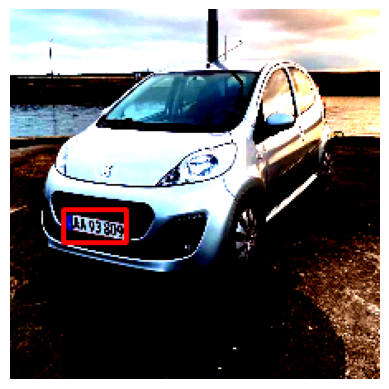

(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


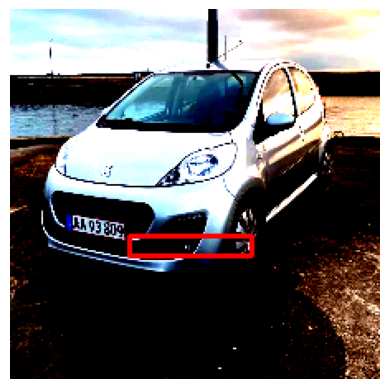

In [ ]:
#print a trainset with predicted label
# train_loader = DataLoader(data_loader, batch_size=1, shuffle=True, num_workers=1)
trained_model.to(device)
trained_model.eval()
train_iter = iter(train_danish_loader)

batch = next(train_iter)

X_batch, y_batch, img_names = batch
print(img_names)
# for i in range(13):
image = batch[0][3]
labels = batch[1][3]
print(f"label: {labels}")

# Get predicted labels
X_batch = X_batch.to(device)
pred = trained_model(X_batch)
print(image.shape)



plot_img_and_boundingbox(image, labels,224)
plot_img_and_boundingbox(image, pred[0],224)

### Experiment: augmenting data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


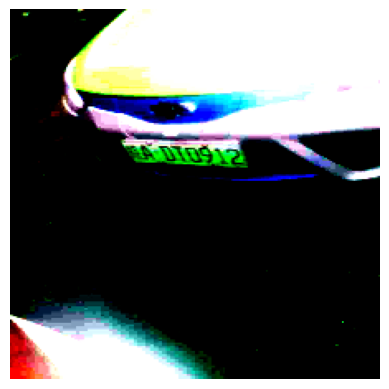

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


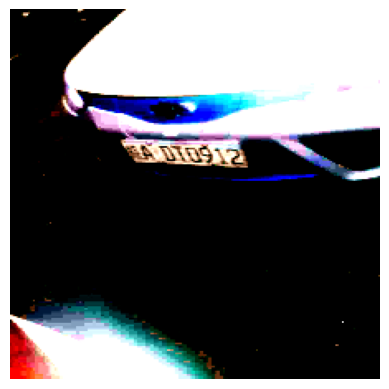

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


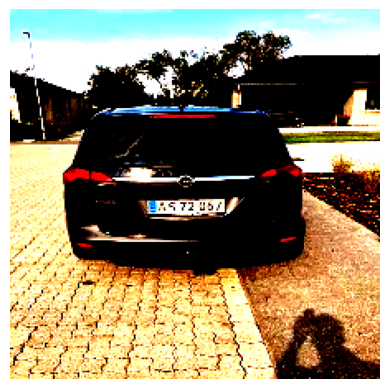

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


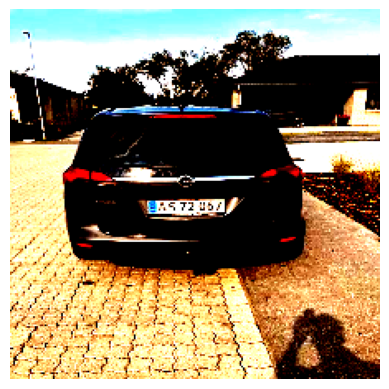

In [ ]:
import random
augmentation_function = lambda x: augment_wrapper(x, [no_augmenter])

val_dataset = LabelFpsDataLoader(VAL_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS, augmentation_function=augmentation_function)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

val_danish_dataset = LabelFpsDataLoader(VAL_DANISH_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS, augmentation_function=augmentation_function)
val_danish_loader = DataLoader(val_danish_dataset, batch_size=VAL_BATCH_SIZE, shuffle = False, num_workers=2, pin_memory=True)

augmentation_green_function = lambda x: augment_wrapper(x, [green_to_white_augmenter])
val_dataset_green = LabelFpsDataLoader(VAL_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS, augmentation_function=augmentation_green_function)
val_loader_green = DataLoader(val_dataset_green, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=False)

val_danish_dataset_green = LabelFpsDataLoader(VAL_DANISH_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS, augmentation_function=augmentation_green_function)
val_danish_loader_green = DataLoader(val_danish_dataset_green, batch_size=VAL_BATCH_SIZE, shuffle = False, num_workers=2, pin_memory=False)

def grayscale_augmenter(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img

def no_augmenter(img):
    return img

def green_to_white_augmenter(img):
    # Convert green hues to whites, check if green is dominant color and then convert to white by setting blue green equal to green, check for each pixel
    # Define a threshold for green
    green_threshold = 120

# Identify pixels that are predominantly green
    green_pixels = (img[:, :, 1] > green_threshold) & (img[:, :, 1] > img[:, :, 0]) & (img[:, :, 1] > img[:, :, 2])

# Update red and blue channels where the condition is True
    img[green_pixels] = np.column_stack([img[green_pixels, 1], img[green_pixels, 1], img[green_pixels, 1]])
    # img[green_val>red_val] = green_val
    return img

def augment_wrapper(img, augmenter_list):
    #apply a random augmenter from the list
    augmenter = random.choice(augmenter_list)
    return augmenter(img)

index_ccpd = 7
index_danish = 3

img_ccpd = next(iter(val_loader))[0][index_ccpd]
label_ccpd = next(iter(val_loader))[1][index_ccpd]
plot_img_and_boundingbox(img_ccpd, label_ccpd,224)

img_ccpd_green = next(iter(val_loader_green))[0][index_ccpd]
label_ccpd_green = next(iter(val_loader_green))[1][index_ccpd]
plot_img_and_boundingbox(img_ccpd_green, label_ccpd_green,224)

img_danish = next(iter(val_danish_loader))[0][index_danish]
label_danish = next(iter(val_danish_loader))[1][index_danish]
plot_img_and_boundingbox(img_danish, label_danish,224)

img_danish_green = next(iter(val_danish_loader_green))[0][index_danish]
label_danish_green = next(iter(val_danish_loader_green))[1][index_danish]
plot_img_and_boundingbox(img_danish_green, label_danish_green,224)


# plot_img_and_boundingbox(image, pred[0],224)


In [63]:
# Constants
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
TRAIN_DANISH_BATCH_SIZE = 8



SUBSET_INDICES = 100
SUBSET_VAL_INDICES = 200
SUBSET_TEST_INDICES = 50

DECODER_EPOCHS = 10
#N_EPOCHS_CYCLIC = 10
N_EPOCHS_LINEAR = 20

USE_TQDM = True
USE_SUBSET = False
NORMALIZED_LABELS = False
EVAL_EVERY = 10

loss_fn = nn.SmoothL1Loss()

# Define dataloaders
augmentation_function = lambda x: augment_wrapper(x, [green_to_white_augmenter])

# Training
train_dataset = LabelFpsDataLoader(TRAIN_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS, augmentation_function=augmentation_function)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True)

# Validation
val_dataset = LabelFpsDataLoader(VAL_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS, augmentation_function=augmentation_function)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Test
test_dataset = LabelFpsDataLoader(TEST_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS, augmentation_function = augmentation_function)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Danish
train_danish_dataset = LabelFpsDataLoader(TRAIN_DANISH_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS, augmentation_function=augmentation_function)
train_danish_loader = DataLoader(train_danish_dataset, batch_size=TRAIN_DANISH_BATCH_SIZE, shuffle = True, num_workers=6, pin_memory=True)

val_danish_dataset = LabelFpsDataLoader(VAL_DANISH_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS, augmentation_function=augmentation_function)
val_danish_loader = DataLoader(train_danish_dataset, batch_size=VAL_BATCH_SIZE, shuffle = False, num_workers=2, pin_memory=True)

test_danish_dataset = LabelFpsDataLoader(TEST_DANISH_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS, augmentation_function=augmentation_function)
test_danish_loader = DataLoader(train_danish_dataset, batch_size=TEST_BATCH_SIZE, shuffle = False, num_workers=2, pin_memory=True)


In [46]:
model = get_new_model()
trained_model, history = train_full_model(model,train_loader, val_danish_loader)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Starting training with decoder...


 10%|█         | 1/10 [01:35<14:19, 95.50s/it]

Epoch 1, In-sample Loss: 18.0002, In-sample Accuracy: 0.0222
Epoch 1, Out-sample Loss: 35.6302, Out-sample Accuracy: 0.0000


100%|██████████| 10/10 [08:35<00:00, 51.53s/it]


Starting full model training...


 55%|█████▌    | 11/20 [10:19<09:16, 61.82s/it]

New best model found with out-sample accuracy: 0.0260
Epoch 11, In-sample Loss: 0.9939, In-sample Accuracy: 0.9340
Epoch 11, Out-sample Loss: 25.3400, Out-sample Accuracy: 0.0260


 90%|█████████ | 18/20 [16:10<01:47, 53.92s/it]


KeyboardInterrupt: 

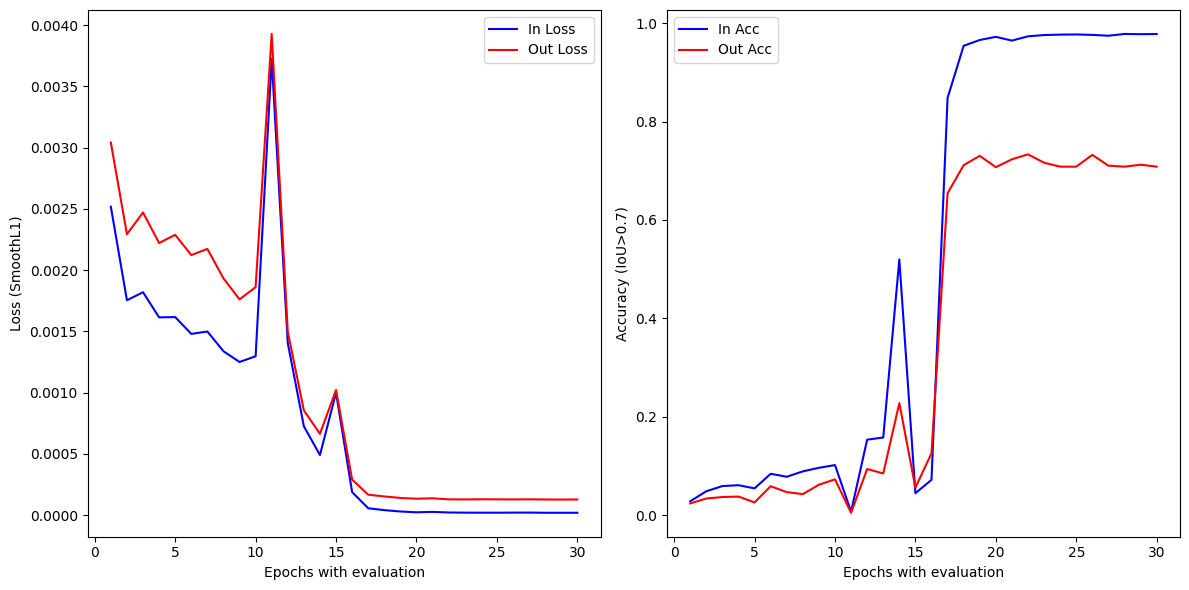

In [77]:
filename = "drop_50_epoch_10_20_earlystop_green_to_white_L1_grayscale"
save_model(trained_model, filename)
save_history_to_file(history, filename)
plot_history(history)

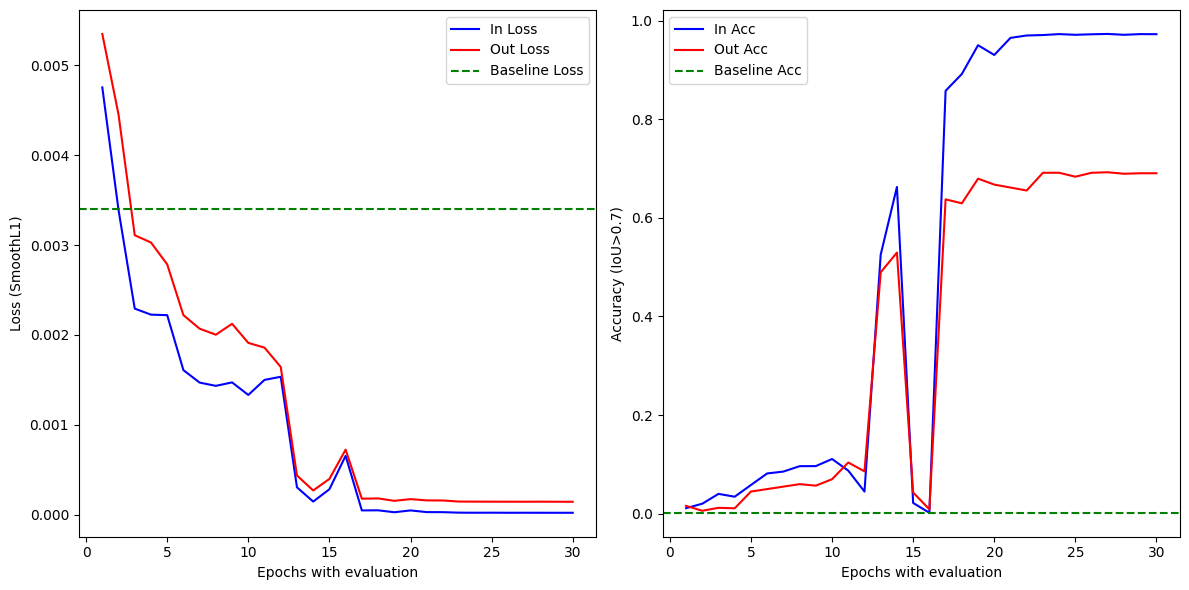

In [20]:
plot_history(history, 0.0034, 0.0013983220135836995)

In [93]:
print(test_model(trained_model, test_loader),0.5)
print(test_model(trained_model, train_danish_loader),0.1)

100%|██████████| 79/79 [01:08<00:00,  1.15it/s]


(0.0, 0.006678968196428275) 0.5


100%|██████████| 10/10 [00:00<00:00, 10.31it/s]

(0.0, 4.250310539646307e-05) 0.1


In [86]:
DECODER_EPOCHS=20
N_EPOCHS_LINEAR=40
model = get_new_model()
trained_danish_model, danish_history = train_full_model(model,train_danish_loader, val_danish_loader)

Adjusting learning rate of group 0 to 1.0000e-03.
Starting training with decoder...


  0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▌         | 1/20 [00:04<01:32,  4.87s/it]

Epoch 1, In-sample Loss: 0.0069, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0069, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|█         | 2/20 [00:09<01:30,  5.00s/it]

Epoch 2, In-sample Loss: 0.0027, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 0.0027, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 15%|█▌        | 3/20 [00:14<01:22,  4.87s/it]

Epoch 3, In-sample Loss: 0.0015, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0015, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 20%|██        | 4/20 [00:19<01:16,  4.78s/it]

Epoch 4, In-sample Loss: 0.0026, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 0.0026, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 25%|██▌       | 5/20 [00:24<01:11,  4.79s/it]

Epoch 5, In-sample Loss: 0.0051, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0051, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 30%|███       | 6/20 [00:28<01:05,  4.71s/it]

Epoch 6, In-sample Loss: 0.0017, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 0.0017, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 35%|███▌      | 7/20 [00:33<01:01,  4.71s/it]

Epoch 7, In-sample Loss: 0.0018, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 0.0018, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 40%|████      | 8/20 [00:38<00:56,  4.73s/it]

Epoch 8, In-sample Loss: 0.0018, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 0.0018, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 45%|████▌     | 9/20 [00:42<00:51,  4.68s/it]

Epoch 9, In-sample Loss: 0.0013, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 0.0013, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 50%|█████     | 10/20 [00:47<00:46,  4.69s/it]

Epoch 10, In-sample Loss: 0.0015, In-sample Accuracy: 0.0000
Epoch 10, Out-sample Loss: 0.0015, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 55%|█████▌    | 11/20 [00:52<00:42,  4.77s/it]

Epoch 11, In-sample Loss: 0.0013, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 0.0013, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 60%|██████    | 12/20 [00:57<00:38,  4.81s/it]

Epoch 12, In-sample Loss: 0.0014, In-sample Accuracy: 0.0000
Epoch 12, Out-sample Loss: 0.0014, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 65%|██████▌   | 13/20 [01:02<00:33,  4.78s/it]

Epoch 13, In-sample Loss: 0.0010, In-sample Accuracy: 0.0000
Epoch 13, Out-sample Loss: 0.0010, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 70%|███████   | 14/20 [01:06<00:28,  4.73s/it]

Epoch 14, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 14, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 75%|███████▌  | 15/20 [01:11<00:23,  4.74s/it]

Epoch 15, In-sample Loss: 0.0005, In-sample Accuracy: 0.0000
Epoch 15, Out-sample Loss: 0.0005, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 80%|████████  | 16/20 [01:15<00:18,  4.69s/it]

Epoch 16, In-sample Loss: 0.0005, In-sample Accuracy: 0.0000
Epoch 16, Out-sample Loss: 0.0005, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 85%|████████▌ | 17/20 [01:20<00:14,  4.67s/it]

Epoch 17, In-sample Loss: 0.0004, In-sample Accuracy: 0.0000
Epoch 17, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 90%|█████████ | 18/20 [01:25<00:09,  4.67s/it]

Epoch 18, In-sample Loss: 0.0003, In-sample Accuracy: 0.0000
Epoch 18, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 95%|█████████▌| 19/20 [01:29<00:04,  4.66s/it]

Epoch 19, In-sample Loss: 0.0004, In-sample Accuracy: 0.0000
Epoch 19, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


Epoch 20, In-sample Loss: 0.0002, In-sample Accuracy: 0.0000
Epoch 20, Out-sample Loss: 0.0002, Out-sample Accuracy: 0.0000
Starting full model training...
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/80 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


  1%|▏         | 1/80 [00:04<06:09,  4.67s/it]

Epoch 1, In-sample Loss: 0.0024, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0024, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  2%|▎         | 2/80 [00:09<06:03,  4.66s/it]

Epoch 2, In-sample Loss: 0.0050, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  4%|▍         | 3/80 [00:13<05:59,  4.67s/it]

Epoch 3, In-sample Loss: 0.0019, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0019, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▌         | 4/80 [00:18<05:55,  4.68s/it]

Epoch 4, In-sample Loss: 0.0013, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 0.0013, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  6%|▋         | 5/80 [00:23<05:53,  4.71s/it]

Epoch 5, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  8%|▊         | 6/80 [00:28<05:49,  4.72s/it]

Epoch 6, In-sample Loss: 0.0017, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 0.0017, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  9%|▉         | 7/80 [00:32<05:43,  4.71s/it]

Epoch 7, In-sample Loss: 0.0018, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 0.0018, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|█         | 8/80 [00:37<05:37,  4.69s/it]

Epoch 8, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 11%|█▏        | 9/80 [00:42<05:33,  4.70s/it]

Epoch 9, In-sample Loss: 0.0003, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 12%|█▎        | 10/80 [00:47<05:37,  4.82s/it]

Epoch 10, In-sample Loss: 0.0025, In-sample Accuracy: 0.0000
Epoch 10, Out-sample Loss: 0.0025, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 14%|█▍        | 11/80 [00:52<05:36,  4.87s/it]

Epoch 11, In-sample Loss: 0.0023, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 0.0023, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 15%|█▌        | 12/80 [00:57<05:31,  4.87s/it]

Epoch 12, In-sample Loss: 0.0023, In-sample Accuracy: 0.0000
Epoch 12, Out-sample Loss: 0.0023, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 16%|█▋        | 13/80 [01:01<05:21,  4.80s/it]

Epoch 13, In-sample Loss: 0.0013, In-sample Accuracy: 0.0000
Epoch 13, Out-sample Loss: 0.0013, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 18%|█▊        | 14/80 [01:06<05:12,  4.73s/it]

Epoch 14, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 14, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 19%|█▉        | 15/80 [01:11<05:06,  4.71s/it]

Epoch 15, In-sample Loss: 0.0015, In-sample Accuracy: 0.0000
Epoch 15, Out-sample Loss: 0.0015, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 20%|██        | 16/80 [01:15<04:56,  4.64s/it]

Epoch 16, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 16, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 21%|██▏       | 17/80 [01:20<04:50,  4.61s/it]

Epoch 17, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 17, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 22%|██▎       | 18/80 [01:24<04:46,  4.62s/it]

Epoch 18, In-sample Loss: 0.0004, In-sample Accuracy: 0.0000
Epoch 18, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 24%|██▍       | 19/80 [01:29<04:43,  4.65s/it]

Epoch 19, In-sample Loss: 0.0003, In-sample Accuracy: 0.0000
Epoch 19, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 25%|██▌       | 20/80 [01:34<04:38,  4.64s/it]

Epoch 20, In-sample Loss: 0.0003, In-sample Accuracy: 0.0000
Epoch 20, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 26%|██▋       | 21/80 [01:38<04:32,  4.62s/it]

Epoch 21, In-sample Loss: 0.0004, In-sample Accuracy: 0.0000
Epoch 21, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 28%|██▊       | 22/80 [01:43<04:29,  4.64s/it]

Epoch 22, In-sample Loss: 0.0016, In-sample Accuracy: 0.0000
Epoch 22, Out-sample Loss: 0.0016, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 29%|██▉       | 23/80 [01:47<04:23,  4.63s/it]

Epoch 23, In-sample Loss: 0.0014, In-sample Accuracy: 0.0000
Epoch 23, Out-sample Loss: 0.0014, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 30%|███       | 24/80 [01:52<04:19,  4.63s/it]

Epoch 24, In-sample Loss: 0.0010, In-sample Accuracy: 0.0000
Epoch 24, Out-sample Loss: 0.0010, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 31%|███▏      | 25/80 [01:57<04:13,  4.61s/it]

Epoch 25, In-sample Loss: 0.0005, In-sample Accuracy: 0.0000
Epoch 25, Out-sample Loss: 0.0005, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 32%|███▎      | 26/80 [02:01<04:08,  4.60s/it]

Epoch 26, In-sample Loss: 0.0004, In-sample Accuracy: 0.0000
Epoch 26, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 34%|███▍      | 27/80 [02:06<04:02,  4.58s/it]

Epoch 27, In-sample Loss: 0.0004, In-sample Accuracy: 0.0000
Epoch 27, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 35%|███▌      | 28/80 [02:10<03:59,  4.60s/it]

Epoch 28, In-sample Loss: 0.0003, In-sample Accuracy: 0.0000
Epoch 28, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 36%|███▋      | 29/80 [02:15<03:56,  4.63s/it]

Epoch 29, In-sample Loss: 0.0002, In-sample Accuracy: 0.0000
Epoch 29, Out-sample Loss: 0.0002, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 38%|███▊      | 30/80 [02:20<03:51,  4.62s/it]

Epoch 30, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 30, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 39%|███▉      | 31/80 [02:24<03:45,  4.61s/it]

Epoch 31, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 31, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 40%|████      | 32/80 [02:29<03:43,  4.65s/it]

Epoch 32, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 32, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 41%|████▏     | 33/80 [02:34<03:38,  4.65s/it]

Epoch 33, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 33, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 42%|████▎     | 34/80 [02:39<03:37,  4.73s/it]

Epoch 34, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 34, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 44%|████▍     | 35/80 [02:43<03:30,  4.68s/it]

Epoch 35, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 35, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 45%|████▌     | 36/80 [02:48<03:28,  4.73s/it]

Epoch 36, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 36, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 46%|████▋     | 37/80 [02:53<03:22,  4.70s/it]

Epoch 37, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 37, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 48%|████▊     | 38/80 [02:57<03:19,  4.75s/it]

Epoch 38, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 38, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 49%|████▉     | 39/80 [03:02<03:13,  4.73s/it]

Epoch 39, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 39, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 50%|█████     | 40/80 [03:07<03:09,  4.73s/it]

Epoch 40, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 40, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 51%|█████▏    | 41/80 [03:12<03:03,  4.71s/it]

Epoch 41, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 41, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 52%|█████▎    | 42/80 [03:16<03:00,  4.75s/it]

Epoch 42, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 42, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 54%|█████▍    | 43/80 [03:21<02:53,  4.70s/it]

Epoch 43, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 43, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 55%|█████▌    | 44/80 [03:26<02:47,  4.66s/it]

Epoch 44, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 44, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 56%|█████▋    | 45/80 [03:30<02:43,  4.68s/it]

Epoch 45, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 45, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 57%|█████▊    | 46/80 [03:35<02:38,  4.67s/it]

Epoch 46, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 46, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 59%|█████▉    | 47/80 [03:40<02:34,  4.69s/it]

Epoch 47, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 47, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 60%|██████    | 48/80 [03:44<02:29,  4.68s/it]

Epoch 48, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 48, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 61%|██████▏   | 49/80 [03:49<02:23,  4.63s/it]

Epoch 49, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 49, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 62%|██████▎   | 50/80 [03:53<02:17,  4.59s/it]

Epoch 50, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 50, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-04.


 64%|██████▍   | 51/80 [03:58<02:15,  4.67s/it]

Epoch 51, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 51, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 65%|██████▌   | 52/80 [04:03<02:11,  4.68s/it]

Epoch 52, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 52, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 66%|██████▋   | 53/80 [04:08<02:06,  4.69s/it]

Epoch 53, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 53, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 68%|██████▊   | 54/80 [04:12<02:01,  4.67s/it]

Epoch 54, In-sample Loss: 0.0001, In-sample Accuracy: 0.0000
Epoch 54, Out-sample Loss: 0.0001, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 69%|██████▉   | 55/80 [04:17<01:57,  4.72s/it]

Epoch 55, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 55, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 70%|███████   | 56/80 [04:22<01:53,  4.74s/it]

Epoch 56, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 56, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 71%|███████▏  | 57/80 [04:26<01:47,  4.69s/it]

Epoch 57, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 57, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 72%|███████▎  | 58/80 [04:32<01:46,  4.83s/it]

Epoch 58, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 58, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 74%|███████▍  | 59/80 [04:36<01:39,  4.73s/it]

Epoch 59, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 59, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 75%|███████▌  | 60/80 [04:41<01:35,  4.76s/it]

Epoch 60, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 60, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 76%|███████▋  | 61/80 [04:45<01:28,  4.67s/it]

Epoch 61, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 61, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 78%|███████▊  | 62/80 [04:50<01:23,  4.65s/it]

Epoch 62, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 62, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 79%|███████▉  | 63/80 [04:55<01:18,  4.63s/it]

Epoch 63, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 63, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 80%|████████  | 64/80 [04:59<01:14,  4.66s/it]

Epoch 64, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 64, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 81%|████████▏ | 65/80 [05:04<01:10,  4.67s/it]

Epoch 65, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 65, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 82%|████████▎ | 66/80 [05:08<01:04,  4.60s/it]

Epoch 66, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 66, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 84%|████████▍ | 67/80 [05:13<00:59,  4.60s/it]

Epoch 67, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 67, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 85%|████████▌ | 68/80 [05:18<00:55,  4.63s/it]

Epoch 68, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 68, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 86%|████████▋ | 69/80 [05:22<00:50,  4.60s/it]

Epoch 69, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 69, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 88%|████████▊ | 70/80 [05:27<00:45,  4.60s/it]

Epoch 70, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 70, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 89%|████████▉ | 71/80 [05:31<00:41,  4.62s/it]

Epoch 71, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 71, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 90%|█████████ | 72/80 [05:36<00:36,  4.60s/it]

Epoch 72, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 72, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 91%|█████████▏| 73/80 [05:41<00:32,  4.65s/it]

Epoch 73, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 73, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 92%|█████████▎| 74/80 [05:45<00:27,  4.63s/it]

Epoch 74, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 74, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 94%|█████████▍| 75/80 [05:50<00:23,  4.62s/it]

Epoch 75, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 75, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 95%|█████████▌| 76/80 [05:54<00:18,  4.57s/it]

Epoch 76, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 76, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-05.


 96%|█████████▋| 77/80 [05:59<00:13,  4.58s/it]

Epoch 77, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 77, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-06.


 98%|█████████▊| 78/80 [06:04<00:09,  4.59s/it]

Epoch 78, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 78, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-06.


 99%|█████████▉| 79/80 [06:08<00:04,  4.59s/it]

Epoch 79, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 79, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 80/80 [06:13<00:00,  4.67s/it]

Epoch 80, In-sample Loss: 0.0000, In-sample Accuracy: 0.0000
Epoch 80, Out-sample Loss: 0.0000, Out-sample Accuracy: 0.0000


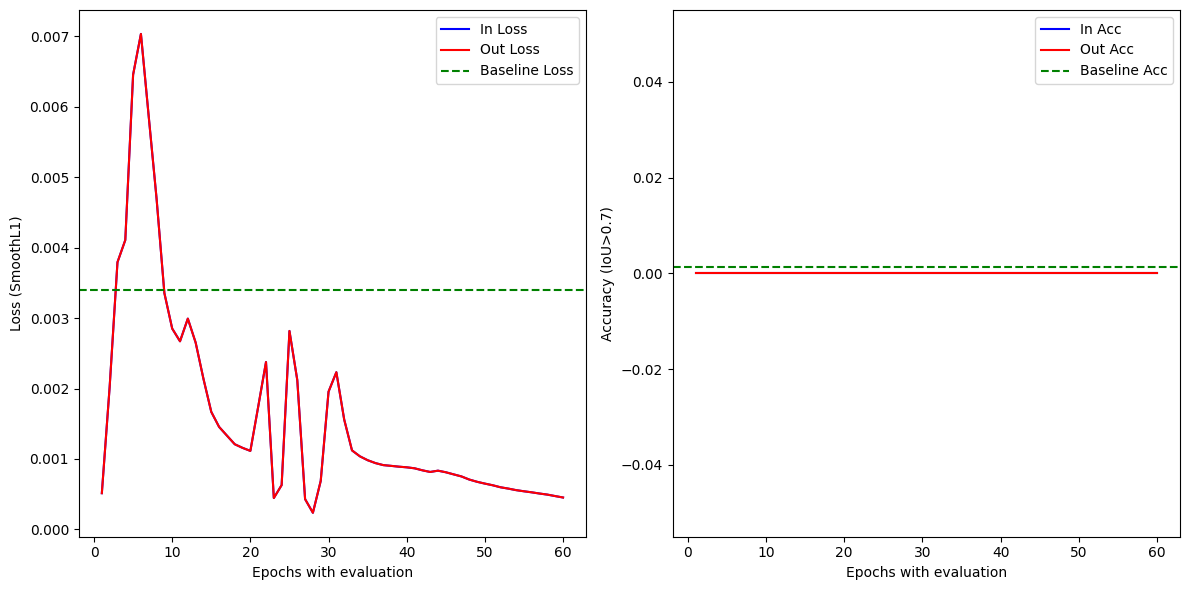

In [83]:
plot_history(danish_history, 0.0034, 0.0013983220135836995)

### Experiment: mean predicter evaluations

In [104]:
mean_labels = torch.zeros(4)
for _, labels, _ in tqdm(train_loader):
    # print(labels)
    mean_labels += torch.sum(labels, dim=0)/len(train_loader.dataset)
print(mean_labels)
mean_labels.to(device)

def test_mean_predictor(data_loader, mean_labels):
    total_true_positives = 0
    total_samples = 0
    loss = torch.zeros(1).to(device)
    # with torch.no_grad():  # Disable gradient computation
    for _, y_batch, _ in tqdm(data_loader):
        y_batch = y_batch.to(device)

        mean_labels_batch = mean_labels.repeat(y_batch.size(0),1).to(device)
        total_true_positives += calculate_true_positives_in_batch(mean_labels_batch, y_batch)
        loss += loss_fn(mean_labels_batch, y_batch)*y_batch.size(0)
        total_samples += y_batch.size(0)  # Accumulate number of samples

    loss = loss / total_samples  # Calculate average loss
    accuracy = total_true_positives / total_samples  # Calculate accuracy
    return accuracy, loss

print("mean predicter acc on train: ", test_mean_predictor(train_loader, mean_labels))
print("mean predicter acc on val: ", test_mean_predictor(val_loader, mean_labels))
print("mean predicter acc on test: ", test_mean_predictor(test_loader, mean_labels))

100%|██████████| 91/91 [00:11<00:00,  8.03it/s]


tensor([ 66.8754,  86.1284, 152.1174, 102.6677])


100%|██████████| 91/91 [00:11<00:00,  8.21it/s]


mean predicter acc on train:  (0.0859767724042295, tensor([133.0043], device='cuda:0'))


100%|██████████| 16/16 [00:05<00:00,  2.96it/s]


mean predicter acc on val:  (0.04395604395604396, tensor([178.6070], device='cuda:0'))


100%|██████████| 79/79 [00:40<00:00,  1.97it/s]

mean predicter acc on test:  (0.0013983220135836995, tensor([338.4029], device='cuda:0'))


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]

mean predicter acc on val:  0.16297652738471782


### Experiment: grayscale training on chinese and danish

In [ ]:
def grayscale_augmenter(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img
def no_augmenter(img):
    return img
def augment_wrapper(img, augmenter_list):
    #apply a random augmenter from the list
    augmenter = random.choice(augmenter_list)
    return augmenter(img)

### Plotting for paper

In [132]:
path = os.path.join(os.getcwd(), 'models', 'drop_50_epoch_10_20_earlystop_green_original_L1.pth')
model = load_model(path)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [133]:
print(test_model(model, train_danish_loader))
print(test_model(model, val_loader))
print(test_model(model, test_loader))

100%|██████████| 10/10 [00:01<00:00,  9.18it/s]


(0.0, 125.39921264648437)


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


(0.0, 101.66236352920532)


 43%|████▎     | 34/79 [00:35<00:47,  1.06s/it]


KeyboardInterrupt: 

### Dataset analysis

/notebooks/CCPD/train/03203125-90_263-192&427_520&526-520&526_201&519_192&427_514&431-0_0_3_25_25_29_29_32-150-10.jpg
3203125


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([3203124.5       , 3203124.53333333, 3203124.56666667,
        3203124.6       , 3203124.63333333, 3203124.66666667,
        3203124.7       , 3203124.73333333, 3203124.76666667,
        3203124.8       , 3203124.83333333, 3203124.86666667,
        3203124.9       , 3203124.93333333, 3203124.96666667,
        3203125.        , 3203125.03333333, 3203125.06666667,
        3203125.1       , 3203125.13333333, 3203125.16666667,
        3203125.2       , 3203125.23333333, 3203125.26666667,
        3203125.3       , 3203125.33333333, 3203125.36666667,
        3203125.4       , 3203125.43333333, 3203125.46666667,
        3203125.5       ]),
 <BarContainer object of 30 artists>)

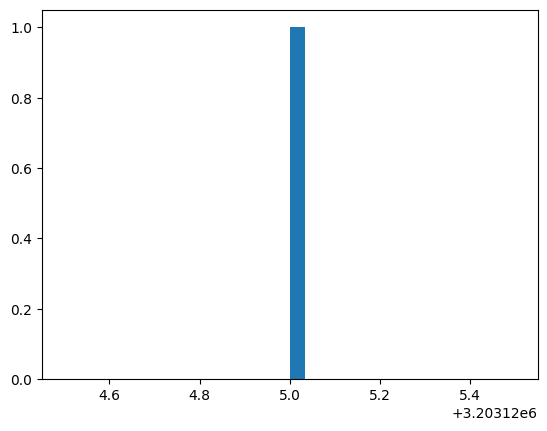

In [111]:
class LabelFpsDataLoader2(Dataset):
    def __init__(self, img_dirs, img_size, is_transform=None, normalize_labels=False, augmentation_function=None):
        self.img_paths = [p for img_dir in img_dirs for p in paths.list_images(img_dir)]
        self.img_size = img_size
        self.is_transform = is_transform
        self.normalize_labels = normalize_labels
        if augmentation_function is None:
            augmentation_function = lambda x: x
        self.augmentation_function = augmentation_function

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_name = self.img_paths[index]
        img = cv2.imread(img_name)
        img = self.augmentation_function(img)
        resized_image = self.transform_image(img)

        file_name = os.path.splitext(os.path.basename(img_name))[0]
        labels = self.extract_labels(file_name, img.shape)
        resized_image = resized_image.transpose(2, 0, 1)
        return resized_image, labels, img_name

    def transform_image(self, img):
        resized_image = cv2.resize(img, self.img_size).astype('float32') / 255.0
        # Normalization - Adjust mean and std if necessary
        mean = np.array([0.485, 0.456, 0.406], dtype=resized_image.dtype)
        std = np.array([0.229, 0.224, 0.225],dtype=resized_image.dtype)

        resized_image = (resized_image - mean) / std  # Normalize
        return resized_image

    def extract_labels(self, file_name, img_shape):
        parts = file_name.split('-')
        points = [self.parse_point(part) for part in parts[2].split('_')]
        ori_w, ori_h = img_shape[1], img_shape[0]
        scale_w, scale_h = self.img_size[0] / ori_w, self.img_size[1] / ori_h
        scaled_points = [(int(x * scale_w), int(y * scale_h)) for x, y in points]
        if self.normalize_labels:
          scaled_points = [(x / self.img_size[0], y / self.img_size[1]) for x, y in scaled_points]
        flattened_labels = [coord for point in scaled_points for coord in point]
        return torch.tensor(flattened_labels, dtype=torch.float32)

    @staticmethod
    def parse_point(point_str):
        return tuple(int(coord) for coord in point_str.split('&'))


train_path_for_analysis = TRAIN_PATH[0]
#get all images in train_path_for_analysis
img_paths = [p for p in paths.list_images(train_path_for_analysis)]
areas = []
#Sample file name: "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg"
for img_path in img_paths:
    print(img_path)
    area = int(os.path.splitext(os.path.basename(img_path))[0].split('-')[0].split('_')[0])
    areas.append(area)
    print(area)
    break

#histogram of areas
plt.hist(areas, bins=30)

### Scaling laws

In [17]:
iterations_per_epoch_full = 90
decoder_epochs_full = 10
encoder_epochs_full = 20

batch_size = 64

EVAL_EVERY= 3
image_count_list = [3000, 4000]
acc_list = []
acc_list_train = []
for image_count in image_count_list:
    iterations_per_epoch = image_count //  batch_size
    DECODER_EPOCHS = min(60,int((90/iterations_per_epoch)*decoder_epochs_full))
    N_EPOCHS_LINEAR = min(200,int((90/iterations_per_epoch)*encoder_epochs_full))

    #pick image_count random indices from 0 to 5700
    indices_train = np.random.choice(5700, image_count, replace=False)
    indices_val = np.random.choice(1000, image_count//5, replace=False)
    # train
    train_dataset = Subset(LabelFpsDataLoader(TRAIN_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS), indices=indices_train)
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True)
    # Validation
    val_dataset = Subset(LabelFpsDataLoader(VAL_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS), indices=indices_val)
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)
    # Test
    test_dataset = LabelFpsDataLoader(TEST_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)

    model = get_new_model()
    trained_model, _ = train_full_model(model, train_loader, val_loader)

    acc, _ = test_model(model, test_loader, 0.7)
    acc_train = test_model(model, train_loader, 0.7)
    acc_list.append(acc)
    acc_list_train.append(acc_train)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Starting training with decoder...


  5%|▌         | 1/19 [00:21<06:26, 21.45s/it]

Epoch 1, In-sample Loss: 49.1552, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 51.4730, Out-sample Accuracy: 0.0000


 21%|██        | 4/19 [01:01<03:57, 15.84s/it]

New best model found with out-sample accuracy: 0.0183
Epoch 4, In-sample Loss: 15.1256, In-sample Accuracy: 0.0377
Epoch 4, Out-sample Loss: 16.3248, Out-sample Accuracy: 0.0183


 37%|███▋      | 7/19 [01:41<03:00, 15.03s/it]

New best model found with out-sample accuracy: 0.0217
Epoch 7, In-sample Loss: 13.5654, In-sample Accuracy: 0.0397
Epoch 7, Out-sample Loss: 14.5901, Out-sample Accuracy: 0.0217


 53%|█████▎    | 10/19 [02:22<02:13, 14.82s/it]

New best model found with out-sample accuracy: 0.0250
Epoch 10, In-sample Loss: 12.8803, In-sample Accuracy: 0.0473
Epoch 10, Out-sample Loss: 13.9643, Out-sample Accuracy: 0.0250


 68%|██████▊   | 13/19 [02:59<01:25, 14.27s/it]

New best model found with out-sample accuracy: 0.0400
Epoch 13, In-sample Loss: 12.3559, In-sample Accuracy: 0.0543
Epoch 13, Out-sample Loss: 13.4492, Out-sample Accuracy: 0.0400


 84%|████████▍ | 16/19 [03:37<00:41, 13.79s/it]

Epoch 16, In-sample Loss: 12.0314, In-sample Accuracy: 0.0547
Epoch 16, Out-sample Loss: 13.2475, Out-sample Accuracy: 0.0350


100%|██████████| 19/19 [04:16<00:00, 13.50s/it]


Epoch 19, In-sample Loss: 11.7650, In-sample Accuracy: 0.0610
Epoch 19, Out-sample Loss: 12.9691, Out-sample Accuracy: 0.0350
Starting full model training...


  3%|▎         | 1/39 [00:32<20:40, 32.64s/it]

New best model found with out-sample accuracy: 0.0117
Epoch 1, In-sample Loss: 18.9312, In-sample Accuracy: 0.0150
Epoch 1, Out-sample Loss: 19.1485, Out-sample Accuracy: 0.0117


 10%|█         | 4/39 [01:44<15:23, 26.40s/it]

New best model found with out-sample accuracy: 0.0167
Epoch 4, In-sample Loss: 11.3535, In-sample Accuracy: 0.0170
Epoch 4, Out-sample Loss: 11.5132, Out-sample Accuracy: 0.0167


 18%|█▊        | 7/39 [02:58<13:59, 26.23s/it]

Epoch 7, In-sample Loss: 14.4566, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 14.2555, Out-sample Accuracy: 0.0000


 26%|██▌       | 10/39 [04:11<12:29, 25.83s/it]

New best model found with out-sample accuracy: 0.0200
Epoch 10, In-sample Loss: 6.7448, In-sample Accuracy: 0.0133
Epoch 10, Out-sample Loss: 7.1046, Out-sample Accuracy: 0.0200


 33%|███▎      | 13/39 [05:24<11:14, 25.94s/it]

New best model found with out-sample accuracy: 0.1367
Epoch 13, In-sample Loss: 5.2004, In-sample Accuracy: 0.0317
Epoch 13, Out-sample Loss: 5.5488, Out-sample Accuracy: 0.1367


 41%|████      | 16/39 [06:37<09:53, 25.81s/it]

New best model found with out-sample accuracy: 0.7500
Epoch 16, In-sample Loss: 0.7947, In-sample Accuracy: 0.9683
Epoch 16, Out-sample Loss: 1.8371, Out-sample Accuracy: 0.7500


 49%|████▊     | 19/39 [07:50<08:35, 25.76s/it]

Epoch 19, In-sample Loss: 0.6964, In-sample Accuracy: 0.9757
Epoch 19, Out-sample Loss: 1.8504, Out-sample Accuracy: 0.7133


 56%|█████▋    | 22/39 [09:03<07:18, 25.80s/it]

Epoch 22, In-sample Loss: 0.6588, In-sample Accuracy: 0.9693
Epoch 22, Out-sample Loss: 1.7808, Out-sample Accuracy: 0.7167


 64%|██████▍   | 25/39 [10:16<06:00, 25.72s/it]

Epoch 25, In-sample Loss: 0.6567, In-sample Accuracy: 0.9810
Epoch 25, Out-sample Loss: 1.8197, Out-sample Accuracy: 0.7217


[0.36076707950459447, 0.6234518577706752, 0.5827007590890931, 0.6903715541350379]
[(0.998, 0.7306550890207291), (0.994, 0.8936888016760349), (0.972, 2.6286663822829723), (0.9792, 2.6787959382503845)]


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  6.47it/s]


(0.714, 12.849176198244095)

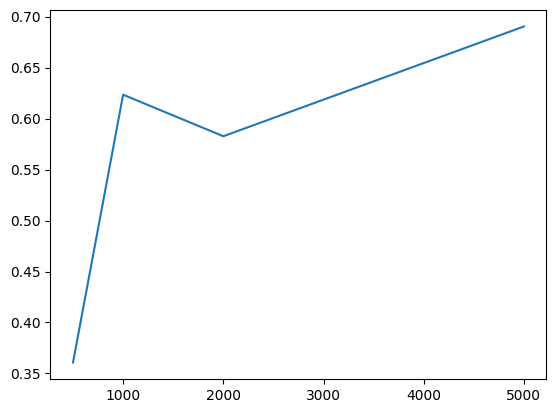

In [26]:
print(acc_list)
print(acc_list_train)
#plot_acc_list
plt.plot(image_count_list, acc_list, label="Test")
test_model(model, val_loader, 0.7)

Text(0.5, 0, 'Training set size')

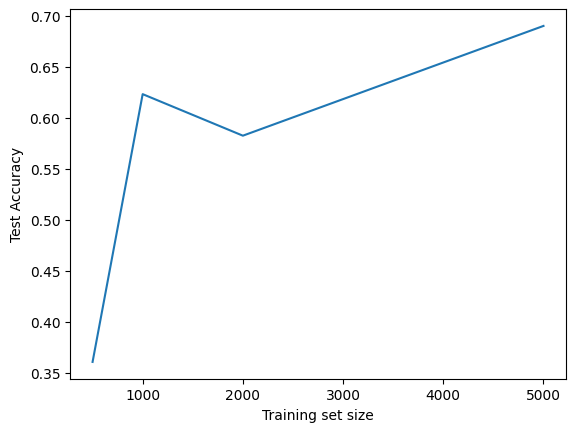

In [ ]:
acc_list =[0.36076707950459447, 0.6234518577706752, 0.5827007590890931, 0.6903715541350379]
#plot_acc_list
plt.plot(image_count_list, acc_list, label="Test")
plt.ylabel("Test Accuracy")
plt.xlabel("Training set size")
#make aspect ratio so that it's less tall
plt.gca().set_aspect(0.5)


print(acc_list)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_heatmap(point_pairs):
    x_min = 0
    x_max = 224
    y_min = 0
    y_max = 224

    x_bins = np.linspace(x_min, x_max, 100)
    y_bins = np.linspace(y_min, y_max, 100)

    heatmap, xedges, yedges = np.histogram2d([], [], bins=[x_bins, y_bins])

    for pair in point_pairs:
        x = [pair[0], pair[2]]
        y = [pair[1], pair[3]]
        heatmap += np.histogram2d(x, y, bins=[x_bins, y_bins])[0]

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(label='Frequency')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

point_pairs = []
for index, (_, labels, _) in enumerate(test_loader):
  for i in range (int(labels.shape[0])):
    point_pairs.append(tuple(labels[i].numpy()))

plot_heatmap(point_pairs)